In [ ]:
import kagglehub
uwrfkaggler_ravdess_emotional_speech_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
uwrfkaggler_ravdess_emotional_song_audio_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-song-audio')

print(f'{uwrfkaggler_ravdess_emotional_speech_audio_path}\n{uwrfkaggler_ravdess_emotional_song_audio_path}')

Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.


100%|██████████| 456M/456M [00:03<00:00, 144MB/s]

Extracting files...


/kaggle/input/ravdess-emotional-speech-audio
/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import IPython.display as ipd
from IPython.display import Audio

import multiprocessing as mp
import timeit
from tqdm import tqdm

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
speech = '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
song = '/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/audio_song_actors_01-24/'

In [ ]:
speech_directory_list = os.listdir(speech)

speech_file_emotion = []
speech_file_path = []
for i in speech_directory_list:
    actor = os.listdir(speech + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        speech_file_emotion.append(int(part[2]))
        speech_file_path.append(speech + i + '/' + f)

In [ ]:
song_directory_list = os.listdir(song)

song_file_emotion = []
song_file_path = []
for i in song_directory_list:
    actor = os.listdir(song + i)
    for f in actor:
        part = f.split('.')[0].split('-')
        song_file_emotion.append(int(part[2]))
        song_file_path.append(song + i + '/' + f)

In [ ]:
emotion_df = pd.DataFrame(speech_file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(speech_file_path, columns=['Path'])
speech_df = pd.concat([emotion_df, path_df], axis=1)
speech_df['Emotions'] = speech_df['Emotions'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
print(speech_df.head())
print("______________________________________________")
print(speech_df.tail())
print("_______________________________________________")
print(speech_df.Emotions.value_counts())

   Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
______________________________________________
     Emotions                                               Path
1435     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
1436    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
1437      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1438  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
1439    angry  /kaggle/input/ravdess-emotional-speech-audio/a...
_______________________________________________
Emotions
neutral     288
surprise    192
disgust     192
fear        192
sad         192
happy       192
angry       192
Name: count, dty

<Axes: xlabel='Emotions'>

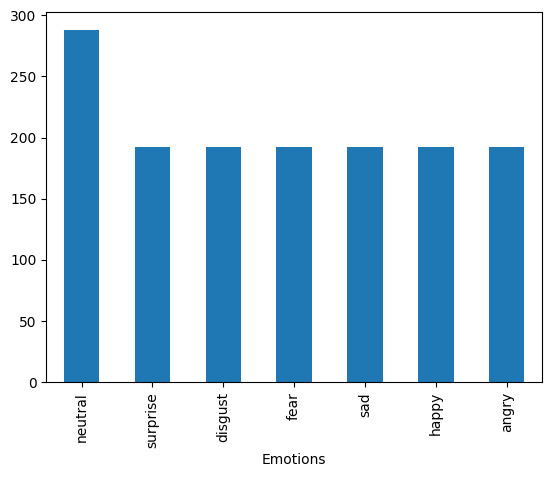

In [ ]:
speech_df.Emotions.value_counts().plot(kind='bar')

In [ ]:
emotion_df = pd.DataFrame(song_file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(song_file_path, columns=['Path'])
song_df = pd.concat([emotion_df, path_df], axis=1)
song_df['Emotions'] = song_df['Emotions'].replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
print(song_df.head())
print("______________________________________________")
print(song_df.tail())
print("_______________________________________________")
print(song_df.Emotions.value_counts())

  Emotions                                               Path
0  neutral  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1      sad  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
2     fear  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
3  neutral  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
4  neutral  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
______________________________________________
     Emotions                                               Path
1007    angry  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1008     fear  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1009  neutral  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1010     fear  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
1011    happy  /root/.cache/kagglehub/datasets/uwrfkaggler/ra...
_______________________________________________
Emotions
neutral    276
sad        184
fear       184
happy      184
angry      184
Name: count, dtype: int64


<Axes: xlabel='Emotions'>

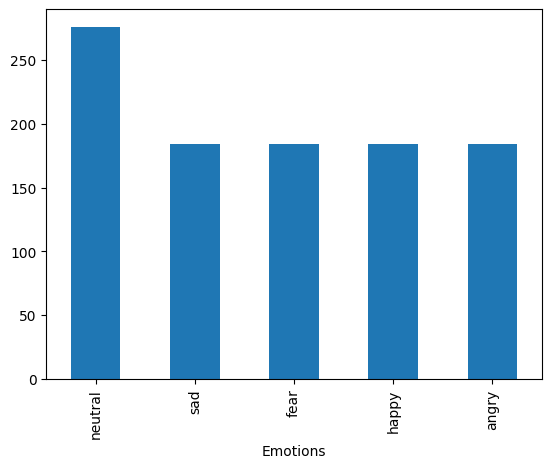

In [ ]:
song_df.Emotions.value_counts().plot(kind='bar')

In [ ]:
speech1,sr_sp = librosa.load(speech_file_path[0])
sr_sp

22050

In [ ]:
song1,sr_so = librosa.load(song_file_path[0])
sr_so

22050

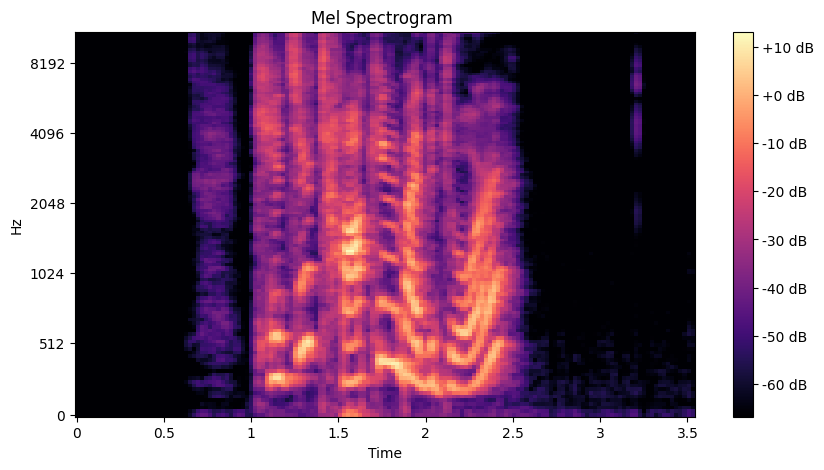

In [ ]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=speech1, sr=sr_sp, n_mels=128, fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr_sp, x_axis='time')
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

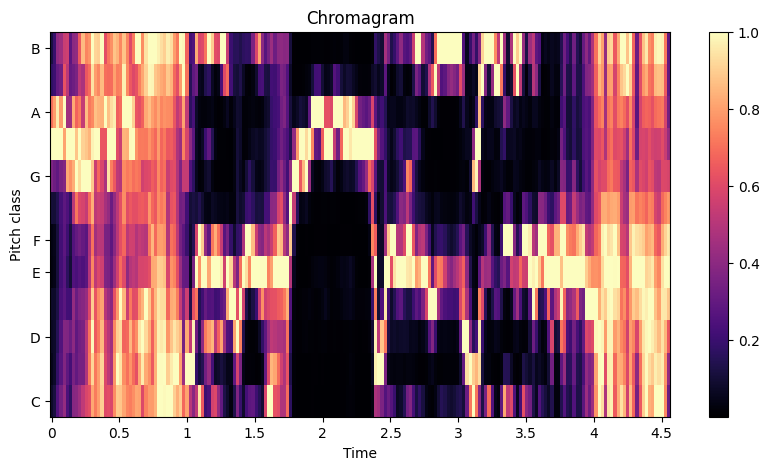

In [ ]:
plt.figure(figsize=(10, 5))
# Extract chroma features
chromagram = librosa.feature.chroma_stft(y=song1, sr=sr_so)
librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
plt.title('Chromagram')
plt.colorbar()

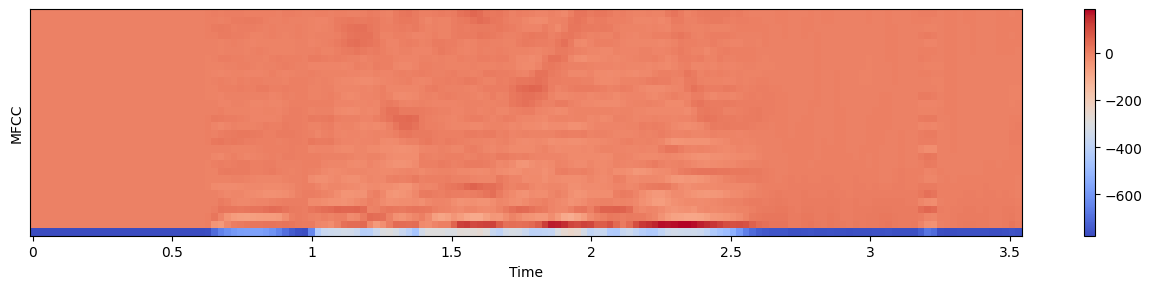

In [ ]:
mfcc = librosa.feature.mfcc(y=speech1, sr=sr_sp, n_mfcc=30)
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

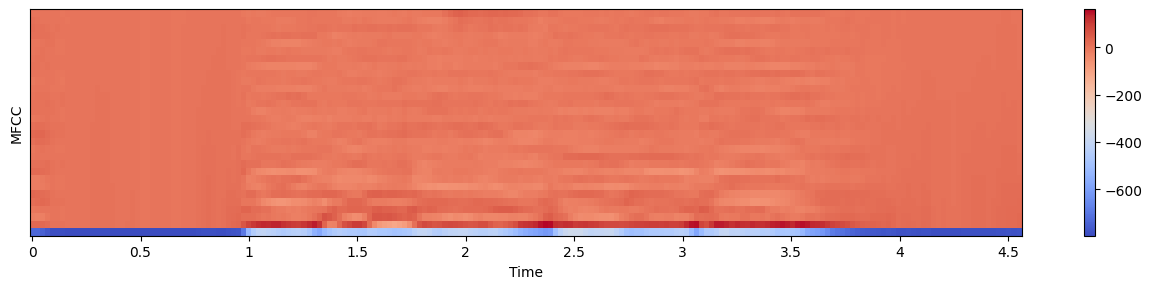

In [ ]:
mfcc = librosa.feature.mfcc(y=song1, sr=sr_so, n_mfcc=30)
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr) # Returns 1D array

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse) # Returns 1D array

def mfcc(data, sr, frame_length=2048, hop_length=512):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return mfcc_result.T # Returns 2D array (time x n_mfcc)

def extract_spectrogram_features(data, sr, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram.T # Returns 2D array (time x n_mels)

def extract_chroma_features(data, sr, frame_length=2048, hop_length=512):
    chromagram = librosa.feature.chroma_stft(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return chromagram.T # Returns 2D array (time x n_chroma)


def extract_features(data,sr=22050,frame_length=2048,hop_length=512, dataset_type='speech'):
    zcr_features = zcr(data,frame_length,hop_length)
    rmse_features = rmse(data,frame_length,hop_length)
    mfcc_features = mfcc(data,sr,frame_length,hop_length)

    if dataset_type == 'speech':
        additional_features = extract_spectrogram_features(data, sr)
    elif dataset_type == 'song':
        additional_features = extract_chroma_features(data, sr, frame_length, hop_length)
    else:
        raise ValueError("dataset_type must be 'speech' or 'song'")

    return zcr_features, rmse_features, mfcc_features, additional_features

def get_features(path, dataset_type='speech', duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)

    # Extract features from original audio
    zcr_orig, rmse_orig, mfcc_orig, additional_orig = extract_features(data, sr, dataset_type=dataset_type)

    # Apply augmentation and extract features
    noised_audio = noise(data)
    zcr_noise, rmse_noise, mfcc_noise, additional_noise = extract_features(noised_audio, sr, dataset_type=dataset_type)

    # Use random rate for stretching
    stretch_rate = np.random.uniform(low=0.5, high=1.5)
    stretched_audio = stretch(data, rate=stretch_rate)
    zcr_stretch, rmse_stretch, mfcc_stretch, additional_stretch = extract_features(stretched_audio, sr, dataset_type=dataset_type)

    shifted_audio = shift(data)
    zcr_shift, rmse_shift, mfcc_shift, additional_shift = extract_features(shifted_audio, sr, dataset_type=dataset_type)

    pitched_audio = pitch(data, sr)
    zcr_pitch, rmse_pitch, mfcc_pitch, additional_pitch = extract_features(pitched_audio, sr, dataset_type=dataset_type)

    # Return a list of tuples, where each tuple contains the 1D and 2D features for one audio sample
    return [
        (zcr_orig, rmse_orig, mfcc_orig, additional_orig),
        (zcr_noise, rmse_noise, mfcc_noise, additional_noise),
        (zcr_stretch, rmse_stretch, mfcc_stretch, additional_stretch),
        (zcr_shift, rmse_shift, mfcc_shift, additional_shift),
        (zcr_pitch, rmse_pitch, mfcc_pitch, additional_pitch)
    ]

# Task
Implement parallel processing to extract features from the speech and song datasets separately. Prepare the data such that i can use speech zcr, rmse, mfcc and spectro as inputs for 1 hybrid model and song zcr, rmse, mfcc and chroma as inputs for the second.

## Import necessary libraries

### Subtask:
Import necessary libraries


**Reasoning**:
Import the multiprocessing library to enable parallel processing.



## Define a worker function for parallel processing

### Subtask:
Create a function that takes a single audio file path and its corresponding emotion label as input, calls `get_features` to extract features (specifying 'speech' or 'song'), and returns the extracted features and label.


**Reasoning**:
Define a function to extract features and return them with the label.



In [ ]:
def process_audio_file(file_path, label):
    """
    Extracts features from an audio file and returns the features and label.

    Args:
        file_path (str): The path to the audio file.
        label (str): The emotion label for the audio file.

    Returns:
        tuple: A tuple containing the extracted features and the label.
    """
    if 'speech' in file_path:
        dataset_type = 'speech'
    elif 'song' in file_path:
        dataset_type = 'song'
    else:
        raise ValueError("file_path must contain either 'speech' or 'song'")

    features = get_features(file_path, dataset_type=dataset_type)
    return features, label

## Prepare input data for parallel processing

### Subtask:
Create lists of tuples, where each tuple contains the audio file path and label for the speech and song datasets separately.


**Reasoning**:
Create lists of tuples containing file paths and labels for both speech and song dataframes.



In [ ]:
speech_data = []
for index, row in speech_df.iterrows():
    speech_data.append((row['Path'], row['Emotions']))

song_data = []
for index, row in song_df.iterrows():
    song_data.append((row['Path'], row['Emotions']))

print(f"Number of speech data entries: {len(speech_data)}")
print(f"Number of song data entries: {len(song_data)}")
print("First 5 speech data entries:")
print(speech_data[:5])
print("First 5 song data entries:")
print(song_data[:5])

Number of speech data entries: 1440
Number of song data entries: 1012
First 5 speech data entries:
[('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-08-01-01-01-02.wav', 'surprise'), ('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-01-01-02.wav', 'neutral'), ('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-02-01-02-02.wav', 'disgust'), ('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-07-01-01-02-02.wav', 'disgust'), ('/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_02/03-01-01-01-02-01-02.wav', 'neutral')]
First 5 song data entries:
[('/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/audio_song_actors_01-24/Actor_19/03-02-02-01-02-01-19.wav', 'neutral'), ('/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-song-audio/versions/1/audio_song_actors_01-2

## Implement parallel feature extraction

### Subtask:
Use `multiprocessing.Pool` to apply the worker function to the speech and song data in parallel, collecting the results.


**Reasoning**:
Use multiprocessing to apply the worker function to the speech and song data in parallel.



In [ ]:
if __name__ == '__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        speech_results = list(tqdm(pool.starmap(process_audio_file, speech_data), total=len(speech_data), desc="Processing speech data"))
        song_results = list(tqdm(pool.starmap(process_audio_file, song_data), total=len(song_data), desc="Processing song data"))

print(f"\nNumber of speech results: {len(speech_results)}")
print(f"Number of song results: {len(song_results)}")

Processing song data: 100%|██████████| 1012/1012 [00:00<00:00, 1622567.14it/s]


Number of speech results: 1440
Number of song results: 1012


## Structure the extracted features and labels

### Subtask:
Process the results from the parallel processing to separate the 1D features (ZCR, RMSE), 2D features (MFCC, Spectrogram/Chroma), and labels into distinct arrays or lists for both speech and song datasets.


**Reasoning**:
Initialize empty lists to store the extracted features and labels for both speech and song data, then iterate through the results to populate these lists and convert them to numpy arrays.



In [ ]:
def pad_or_truncate(arr, max_len):
    """Pads or truncates a 2D array to a specified length."""
    if arr.shape[0] > max_len:
        return arr[:max_len, :]
    elif arr.shape[0] < max_len:
        padding = np.zeros((max_len - arr.shape[0], arr.shape[1]))
        return np.vstack((arr, padding))
    return arr

speech_zcr_stats = []
speech_rmse_stats = []
speech_mfcc_2d_padded = []
speech_spectrogram_2d_padded = []
speech_labels = []

song_zcr_stats = []
song_rmse_stats = []
song_mfcc_2d_padded = []
song_chroma_2d_padded = []
song_labels = []

# Determine the maximum length for 2D features
max_mfcc_len_speech = 0
max_spectrogram_len_speech = 0
max_mfcc_len_song = 0
max_chroma_len_song = 0

for features, label in speech_results:
    for zcr, rmse, mfcc, spectrogram in features:
        max_mfcc_len_speech = max(max_mfcc_len_speech, mfcc.shape[0])
        max_spectrogram_len_speech = max(max_spectrogram_len_speech, spectrogram.shape[0])

for features, label in song_results:
    for zcr, rmse, mfcc, chroma in features:
        max_mfcc_len_song = max(max_mfcc_len_song, mfcc.shape[0])
        max_chroma_len_song = max(max_chroma_len_song, chroma.shape[0])

# Pad or truncate 2D features and collect all features and labels
for features, label in speech_results:
    for zcr, rmse, mfcc, spectrogram in features:
        speech_zcr_stats.append([np.mean(zcr), np.std(zcr)])
        speech_rmse_stats.append([np.mean(rmse), np.std(rmse)])
        speech_mfcc_2d_padded.append(pad_or_truncate(mfcc, max_mfcc_len_speech))
        speech_spectrogram_2d_padded.append(pad_or_truncate(spectrogram, max_spectrogram_len_speech))
        speech_labels.append(label)


for features, label in song_results:
    for zcr, rmse, mfcc, chroma in features:
        song_zcr_stats.append([np.mean(zcr), np.std(zcr)])
        song_rmse_stats.append([np.mean(rmse), np.std(rmse)])
        song_mfcc_2d_padded.append(pad_or_truncate(mfcc, max_mfcc_len_song))
        song_chroma_2d_padded.append(pad_or_truncate(chroma, max_chroma_len_song))
        song_labels.append(label)

speech_zcr_stats = np.array(speech_zcr_stats)
speech_rmse_stats = np.array(speech_rmse_stats)
speech_mfcc_2d_padded = np.array(speech_mfcc_2d_padded)
speech_spectrogram_2d_padded = np.array(speech_spectrogram_2d_padded)
speech_labels = np.array(speech_labels)

song_zcr_stats = np.array(song_zcr_stats)
song_rmse_stats = np.array(song_rmse_stats)
song_mfcc_2d_padded = np.array(song_mfcc_2d_padded)
song_chroma_2d_padded = np.array(song_chroma_2d_padded)
song_labels = np.array(song_labels)

print("Speech Data Shapes:")
print("ZCR Stats (mean, std):", speech_zcr_stats.shape)
print("RMSE Stats (mean, std):", speech_rmse_stats.shape)
print("MFCC (Padded 2D):", speech_mfcc_2d_padded.shape)
print("Spectrogram (Padded 2D):", speech_spectrogram_2d_padded.shape)
print("Labels:", speech_labels.shape)

print("\nSong Data Shapes:")
print("ZCR Stats (mean, std):", song_zcr_stats.shape)
print("RMSE Stats (mean, std):", song_rmse_stats.shape)
print("MFCC (Padded 2D):", song_mfcc_2d_padded.shape)
print("Chroma (Padded 2D):", song_chroma_2d_padded.shape)
print("Labels:", song_labels.shape)

Speech Data Shapes:
ZCR Stats (mean, std): (7200, 2)
RMSE Stats (mean, std): (7200, 2)
MFCC (Padded 2D): (7200, 216, 20)
Spectrogram (Padded 2D): (7200, 216, 128)
Labels: (7200,)

Song Data Shapes:
ZCR Stats (mean, std): (5060, 2)
RMSE Stats (mean, std): (5060, 2)
MFCC (Padded 2D): (5060, 216, 20)
Chroma (Padded 2D): (5060, 216, 12)
Labels: (5060,)


In [ ]:
# Define file paths for saving
speech_zcr_path = 'speech_zcr_stats.npy'
speech_rmse_path = 'speech_rmse_stats.npy'
speech_mfcc_path = 'speech_mfcc_2d_padded.npy'
speech_spectrogram_path = 'speech_spectrogram_2d_padded.npy'
speech_labels_path = 'speech_labels.npy'

song_zcr_path = 'song_zcr_stats.npy'
song_rmse_path = 'song_rmse_stats.npy'
song_mfcc_path = 'song_mfcc_2d_padded.npy'
song_chroma_path = 'song_chroma_2d_padded.npy'
song_labels_path = 'song_labels.npy'

# Save speech data
np.save(speech_zcr_path, speech_zcr_stats)
np.save(speech_rmse_path, speech_rmse_stats)
np.save(speech_mfcc_path, speech_mfcc_2d_padded)
np.save(speech_spectrogram_path, speech_spectrogram_2d_padded)
np.save(speech_labels_path, speech_labels)

# Save song data
np.save(song_zcr_path, song_zcr_stats)
np.save(song_rmse_path, song_rmse_stats)
np.save(song_mfcc_path, song_mfcc_2d_padded)
np.save(song_chroma_path, song_chroma_2d_padded)
np.save(song_labels_path, song_labels)

print("Speech and song features and labels saved successfully.")

Speech and song features and labels saved successfully.
